In [1]:
!pip install pyddm


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import pyddm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_rt = pd.read_csv("Haddara2022Expt2_clean.csv")
df_rt['correct'] = np.where(df_rt['Stimulus'] == df_rt['Response'], 1,0 ) 
df_rt = df_rt[(df_rt.RT_dec > 0.2) & (df_rt.RT_dec < 2)]
df_rt.head()

,Subj_idx,Stimulus,Response,Confidence,RT_dec,RT_conf,Day,Feedback,correct
0,1,1,1,4,0.496,0.350,1,1,1
1,1,2,1,2,0.897,0.284,1,1,0
2,1,2,2,3,1.558,0.867,1,1,1
3,1,1,1,4,0.297,0.265,1,1,1
4,1,1,1,4,0.407,0.219,1,1,1


In [5]:
#First, load the data we wish to use
# df_rt = df_rt[df_rt["monkey"] == 1] # Only monkey 1
df_participant = df_rt[df_rt.Subj_idx == 1].reset_index()
df_participant.to_csv('participant.csv')
sample = pyddm.Sample.from_pandas_dataframe(df_participant, rt_column_name="RT_dec", correct_column_name="correct")

In [17]:
m = pyddm.Model(drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
          noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=4)),
          overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)), 
           dt = 0.01, T_dur = 5)

# pyddm.plot.model_gui_jupyter(model=m, sample=sample)

In [48]:
pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

Info: Params [0.96718523 1.32370448 0.1664465 ] gave 2397.7175317508854


Model(name='', drift=DriftConstant(drift=Fitted(0.9671852281534081, minval=-5, maxval=5)), noise=NoiseConstant(noise=Fitted(1.3237044800610689, minval=0.2, maxval=4)), bound=BoundConstant(B=1), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.16644649613839832, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=2.0, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='Negative log likelihood', value=2397.7175317508854, nparams=3, samplesize=3157, mess=''))

In [27]:
import numpy as np
from scipy.optimize import minimize
from pyddm.models import DriftConstant, NoiseConstant, OverlayNonDecision
from pyddm import Model, Fittable
import pyddm as ddm

m = ddm.Model(drift=ddm.DriftConstant(drift = 1),
              noise=ddm.NoiseConstant(noise=1),
              bound=ddm.BoundConstant(B=1),
              T_dur=5.0)

def loss(model,data):
    m = model
    sol = m.solve()
    pdf_lower, pdf_upper = sol.pdf_lower, sol.pdf_upper

    loglike = 0
    for _, row in data.iterrows():
        datapoint = row['RT_dec']
        is_correct = bool(row['correct'])
        loglike += np.log(pdf_upper(datapoint)) if is_correct else np.log(pdf_lower(datapoint))
    return -loglike

# initial guess for the parameters
initial_guess = [0, 1, 0.1,]

# bounds for the parameters
bounds = [(-5, 5), (0.1, 4), (0, 0.5)]

result = minimize(loss, initial_guess, args=(m, df_participant,), bounds=bounds)


TypeError: loss() takes 2 positional arguments but 3 were given

In [50]:
def loss(model,data):
    m = model
    sol = m.solve()
    pdf_lower, pdf_upper = sol.pdf('error'), sol.pdf('correct')

    loglike = 0
    for _, row in data.iterrows():
        datapoint = row['RT_dec'] * 1000
        is_correct = bool(row['correct'])
        loglike += np.log(pdf_upper[datapoint]) if is_correct else np.log(pdf_lower[datapoint])
    return -loglike

loss(m, df_participant)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [52]:
sol = m.solve()
pdf_lower, pdf_upper = sol.pdf('error'), sol.pdf('correct')

loglike = 0

pdf_lower.shape

(401,)

In [25]:
sol = m.solve()
pdf_lower, pdf_upper = sol.pdf('error'), sol.pdf('correct')

loglike = 0
for idx, row in df_participant.iterrows():
    # datapoint = row['RT_dec']
    
    is_correct = bool(row['correct'])
    loglike += np.log(pdf_upper[idx]) if is_correct else np.log(pdf_lower[idx])

IndexError: index 1 is out of bounds for axis 0 with size 0

/Users/nicobruno/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RT_conf', ylabel='Density'>

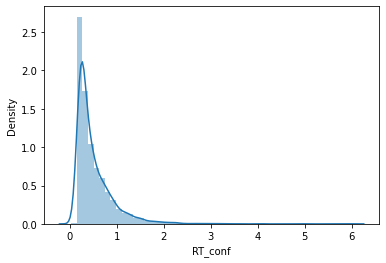

In [57]:
sns.distplot(df_participant['RT_conf'])

/Users/nicobruno/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Confidence', ylabel='Density'>

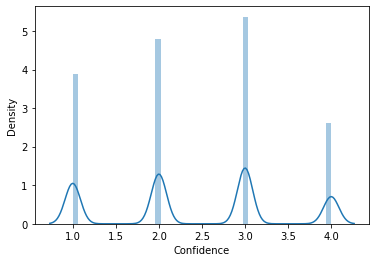

In [58]:
sns.distplot(df_rt['Confidence'])

In [61]:
df_rt.groupby(['Subj_idx', 'Confidence']).mean()

Stimulus  Response  RT_dec  RT_conf   Day  Feedback  \
Subj_idx Confidence                                                        
1        1                337       337     337      337   337       337   
         2               1476      1476    1476     1476  1476      1476   
         3                972       972     972      972   972       972   
         4                372       372     372      372   372       372   
2        1                101       101     101      101   101       101   
...                       ...       ...     ...      ...   ...       ...   
59       4                127       127     127      127   127       127   
60       1                  4         4       4        4     4         4   
         2                941       941     941      941   941       941   
         3               2196      2196    2196     2196  2196      2196   
         4                142       142     142      142   142       142   

                     correct  
Subj_idx Confidence           
1        1               337  
         2              1476  
         3               972  
         4               372  
2        1               101  
...                      ...  
59       4               127  
60       1                 4  
         2               941  
         3              2196  
         4               142  

[238 rows x 7 columns]